## M10 Fig. $SF_{\infty}$ vs $L_{Edd}$

Spin-off from `Trends_quasar_properties.ipynb`

In [4]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import os
import pandas as pd
import healpy as hp
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import unique
from astropy.table import Column
from astropy.table import join
from matplotlib import rcParams 
from scipy.stats import binned_statistic as bs 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

First, use just Chelsea's data, and try to reproduce what she did... The data source can always be changed 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


POLYFIT  slope a =  -0.17558381708656243
Saved as macleod2010_Fig15_Shen2011_sdss_gridsize_20.png


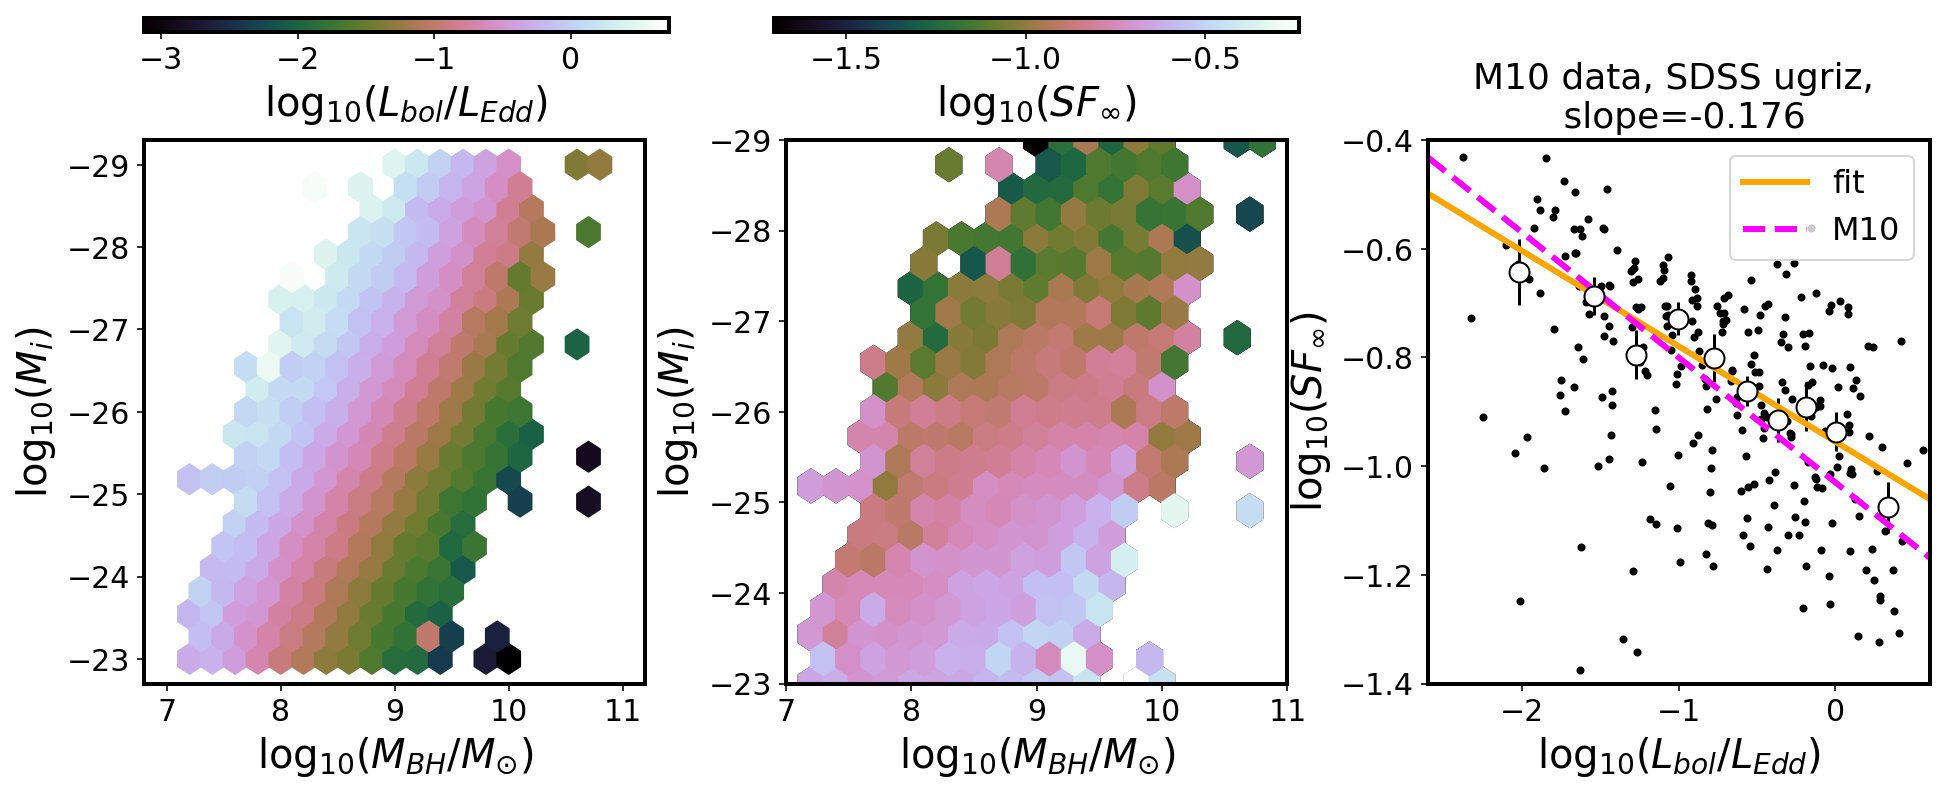

In [66]:
data = Table.read('../code/s82drw_ugriz_shen2011_shen2008.txt', format='ascii')

%config InlineBackend.figure_format='retina'
%matplotlib inline
import seaborn as sns
cmap = 'cubehelix'

# plotted quantities : 
# absolute i-band magnitude K-corr to z=2 
MI =data['MI_Z2'] # Shen2011 

# redshift  : Shen2011 
z =  data['REDSHIFT']

# black hole mass from Shen+2011
MBH = data['LOGBH']

# Eddington ratio : Shen2011
# log(L/LEdd ) = log( L / 1.26e38 MBH / Msun)

logEddRatio = data['LOGEDD_RATIO'] # Shen2011
#logEddRatio = qso['LOGLBOL'] - np.log10(1.5) - 38 - qso['LOGBH']  # Shen 2011 but with 
# Chlsea's definition of LEdd (1.5 rather than 1.26 )
#logEddRatio = qso['Lbol'] - np.log10(1.5) - 38 - qso['mass_BH_1']  # shen 2008


source = 'chelsea'
seg = 'sdss'

if source == 'celerite': 
    
    lambdaobs = 6250 # angstroms  - since these are the results for 
    # combined SDSS r-band, centered on 6250 Angstroms 
    lambdaRF = lambdaobs /  (1.+z)

    seg = 'sdss-ps1' # sdss'# 'sdss-ps1'

    tauRF = data['tauEXP_'+seg] / (1.+z)  # shift to rest frame 
    tau4000 = tauRF * np.power(4000/lambdaRF, 0.17) # B=0.17 for tau

    sfinf = data['sigmaEXP_'+seg] * np.sqrt(2) # no need to shift anything 
    
if source == 'chelsea' : 
    #sf4000 = sfinf * np.power(4000 / lambdaRF, -0.479 ) # B = -0.479 for SFinf 
    sf4000 = data['SFinf4000']

fig,axs = plt.subplots(1,3, figsize=(16,5))
ax = np.ravel(axs)

gridsize=20
#m = logEddRatio  >  -4 
m2 = data['Plike'] - data['Pnoise'] > 2 
m3 = data['Plike'] - data['Pinf'] > 0.05 
m4 = data['edge'] == 0 
m = m2&m3&m4


#m = (qso['tauEXP_'+seg] > 5 )&(logEddRatio > -4)


if seg == 'sdss-ps1':
    extent0 = [7,11, -23,-29]
    extent1 = [-2.6,0.6, -1.2,-0.2]
    
if seg == 'sdss':
    extent0 = [7,11, -23,-29]
    extent1 = [-2.6,0.6, -1.4,-0.4]
    
    
################################################
# left panel : find median logEddRatio 
################################################

iax = 0 
# set bottom and height for both colorbars
bottom, height =  1.03, 0.02

image = ax[iax].hexbin(MBH[m], MI[m], logEddRatio[m],
                     extent = extent0, cmap=cmap, gridsize=gridsize,
                    reduce_C_function = np.median, label='')
ax[iax].invert_yaxis()
ax[iax].set_xlabel(r'$\log_{10}{(M_{BH}/M_{\odot})}$')
ax[iax].set_ylabel(r'$\log_{10}{(M_{i})}$')


# get left and right coordinates in figure units 
# for left axis 
l,b,w,h = ax[0].get_position().bounds
cax = fig.add_axes([l,bottom,w,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label=r'$\log_{10}{(L_{bol} / L_{Edd} )}$')


################################################
# middle panel : find median SF_inf 
################################################
iax = 1 

# of the two hexbins below the first one is overplotted by the 
# second one. I need that so that I would have the median 
# of f_Edd,  rather the median of log(f_Edd), as done above...

# I make sure that the median is on fEdd,  not the log10(fEdd)
image1 = ax[iax].hexbin(MBH[m], MI[m], np.power(10,logEddRatio[m]),
                     extent = extent0, cmap=cmap, gridsize=gridsize,
                    reduce_C_function = np.median, label='')

bin_med_fEdd = image1.get_array()

# also ,find median SFEdd per bin...
image2 = ax[iax].hexbin(MBH[m], MI[m], sf4000[m],
                     extent = extent0, cmap=cmap, gridsize=gridsize,
                     reduce_C_function = np.median, label='')
bin_med_sf4000 = image2.get_array()


# for plotting , use logarthmic bins ...
image3 = ax[iax].hexbin(MBH[m], MI[m], np.log10(sf4000[m]),
                     extent = extent0, cmap=cmap, gridsize=gridsize,
                     reduce_C_function = np.median, label='')
ax[iax].invert_yaxis()
ax[iax].set_xlabel(r'$\log_{10}{(M_{BH}/M_{\odot})}$')
ax[iax].set_ylabel(r'$\log_{10}{(M_{i})}$')

# get left and right coordinates in figure units 
# for left axis 
l,b,w,h = ax[1].get_position().bounds
cax = fig.add_axes([l,bottom,w,height])
plt.colorbar(mappable = image3, cax = cax, orientation='horizontal',
             label=r'$\log_{10}{(SF_{\infty})}$'
            )


################################################
# right panel : plot the log(median(f_Edd))  vs log (median(SF_inf ))
################################################
iax = 2 
# the grids for the two are identical, and could be obtained 
# as a (2xN)  list of (x,y) vertices for each hexbin...
# with image.get_offsets()
# and I say that image.get_offsets() == image1.get_offsets()


#x,y = logEddRatio[m].data, np.log10(sf4000[m].data)


#ax[1].hexbin(x,y,bins='log',mincnt=1, gridsize=gridsize,
#            extent = extent1)

# plot also the  log (median (SFinf ) ) and median (log(LEdd)) ... 
# select only sf_4000 and fEdd that are within the plot limits....
x_,y_  = np.log10(bin_med_fEdd), np.log10(bin_med_sf4000)
xmin, xmax = extent1[0],extent1[1]
ymin, ymax = extent1[2],extent1[3]
mx = (xmin < x_) & (x_ < xmax)
my = (ymin < y_) & (y_ < ymax)

x = x_[mx&my]
y = y_[mx&my]

ax[iax].plot(x,y, 'k.')
ax[iax].set_xlim(xmin,xmax)
ax[iax].set_ylim(ymin, ymax)
ax[iax].set_ylabel(r'$\log_{10}{(SF_{\infty})}$')
ax[iax].set_xlabel(r'$\log_{10}{(L_{bol} / L_{Edd})}$')


# for this distribution of black points, divide into 10 bins along log(fEdd),
# so that each bin has equal number of points .... 

def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt), np.sort(x))

bin_edges  = histedges_equalN(x, 10)
# plot vertical lines to illustrate non-uniform bin boundaries 
# for edge in bin_edges : 
#     ax[1].axvline(edge)
#bin_centers  =  (bin_edges[1:] + bin_edges[:-1] ) /2.
stat_med, bin_edges1,  binnumber = bs(x,y,statistic='median', bins=bin_edges)
bin_centers1 = (bin_edges1[1:] + bin_edges1[:-1] ) /2.


# get the count per bin
stat_count, bin_edges1,  binnumber = bs(x,x,statistic='count', bins=bin_edges)

N = stat_count[0]

# get the RMS, estimated by sigmaG,  per bin 
sigmaG = lambda x : 0.7413*(np.percentile(x,75) - np.percentile(x,25))
stat_RMS, bin_edges1,  binnumber = bs(x,y,statistic=sigmaG, bins=bin_edges)

sigma_median = 1.25 * stat_RMS / np.sqrt(N)
# markeredgecolor or mec
# markeredgewidth or mew
# markerfacecolor or mfc
# ecolor specifies the color of errorbar(s) 
ax[iax].errorbar(bin_centers1, stat_med, sigma_median, fmt='o', mec = 'black', mfc='white',
            ecolor = 'black', capthick=2,
           markersize=10, )


# fit with the straight line 
sy = sigma_median  * np.ones_like(stat_med)
z = np.polyfit(bin_centers1, stat_med,1, w = 1 / sy)
a_fit_poly,  b_fit_poly  = z 
print('POLYFIT  slope a = ', a_fit_poly)
# use poly1 object for plotting the straight line 
p1 = np.poly1d(z) # 
xmin, xmax = ax[iax].get_xlim()
xp = np.linspace(xmin,xmax,1000)
ax[iax].plot(xp, p1(xp), lw=3, ls='-', c='orange', label='fit')
# this is equivalent to defining a fitting function and providing it 
# with sigma_y  for curve_fit()

# plot Chelsea's slope...
ax[iax].plot(xp, -0.23*xp - 1.03, lw=3, ls='--', c='magenta',  label='M10')

ax[iax].legend(loc='upper right', fontsize=16)

ax[iax].set_title('M10 data, SDSS ugriz, \n slope=%.3f'%a_fit_poly)
fig.subplots_adjust(wspace=0.28)
#fig.text(0.45,0.99,'Shen+2011', fontsize=19)
figname =  'macleod2010_Fig15_Shen2011_'+seg+'_gridsize_'+str(gridsize)+'.png'
print('Saved as %s'%figname)
plt.savefig(figname, bbox_inches='tight', dpi=100)

Do the same but using binned_statistic_2d  to find the averages per bin... And make bins square...

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


POLYFIT  slope a =  -0.16625903554969057
Saved as macleod2010_Fig15_Shen2011_sdss_gridsize_15_square.png


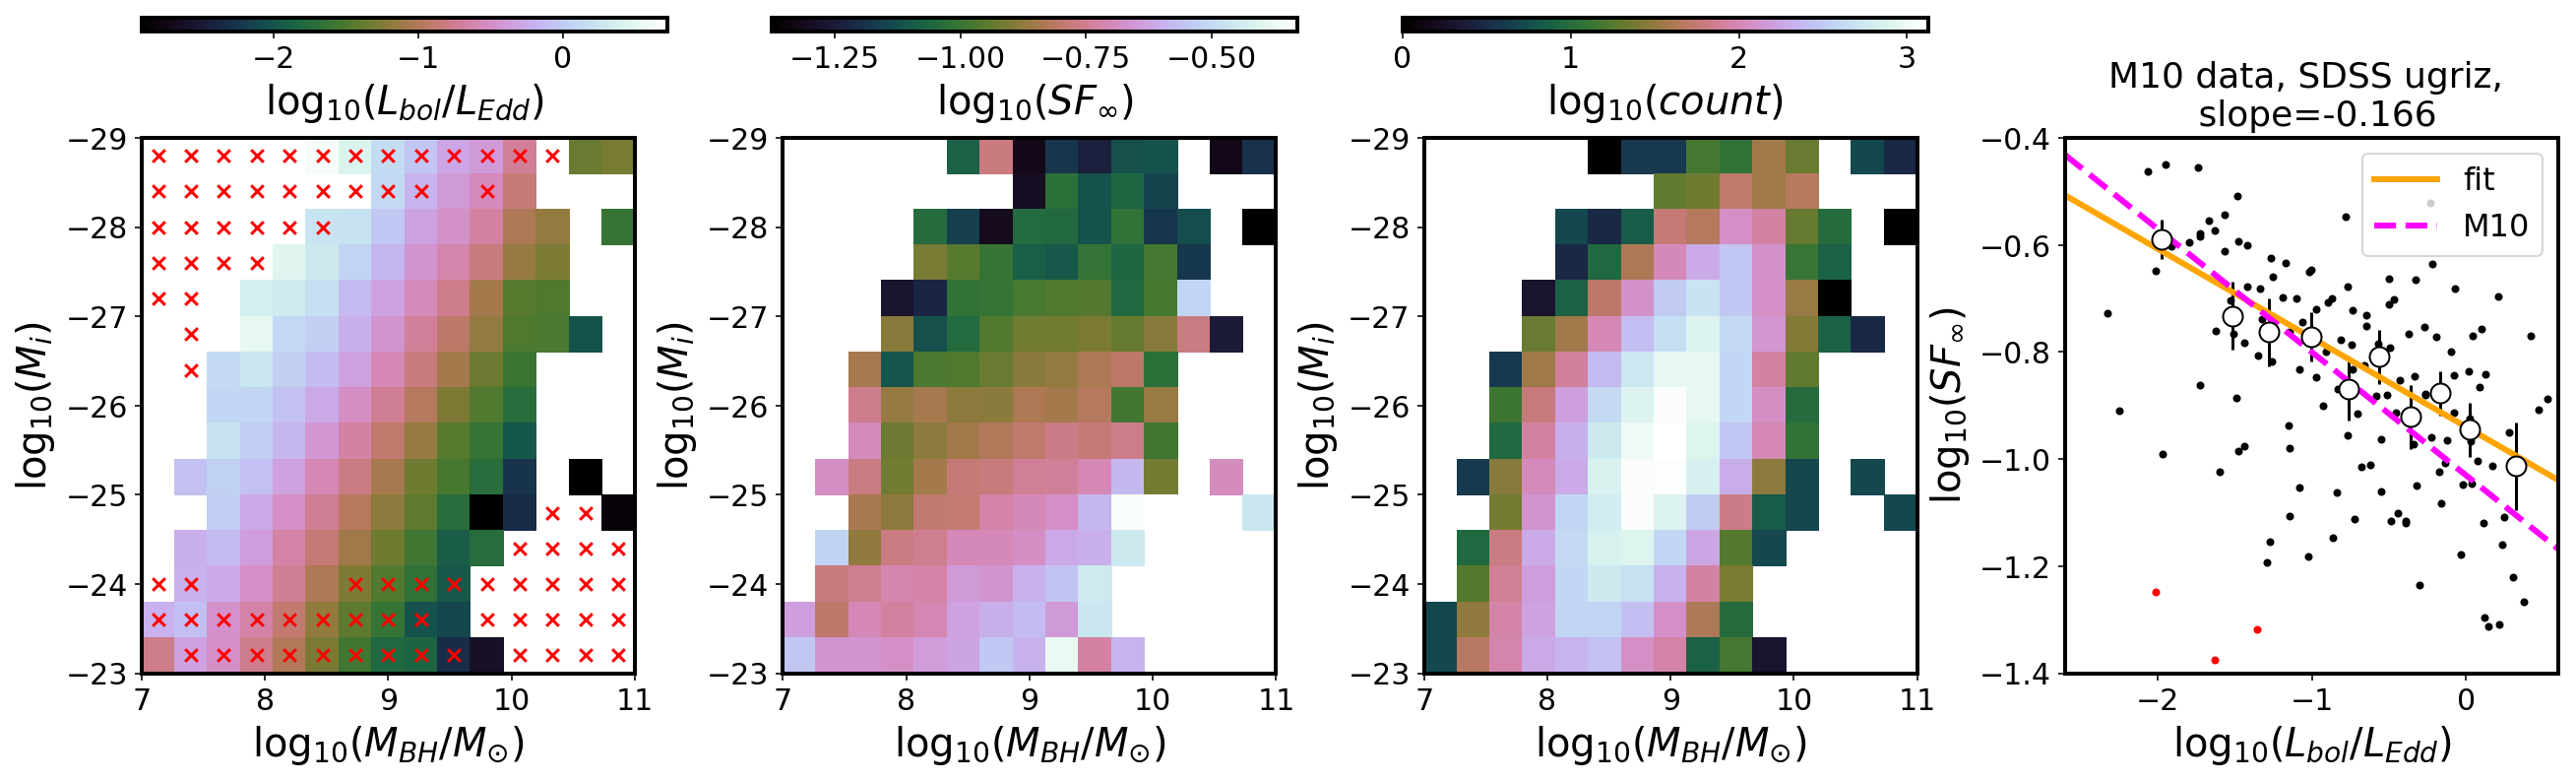

In [403]:

from scipy.stats import binned_statistic_2d

%config InlineBackend.figure_format='retina'
%matplotlib inline
import seaborn as sns
cmap = 'cubehelix'

gridsize = 15

def make_image(stats,ax,cmap, log=False):
    ''' convenience function 
    to take the outcome of binned_statistic_2d(),
    which has 3 elements:  the z_statistic , 
    x_edges and y_edges.  '''
    H, xedges, yedges = stats[0].T, stats[1], stats[2]
    X,Y = np.meshgrid(xedges, yedges)
     
    # Plot 2D histogram using pcolor
    if log :  # use logarithm of z aggregate 
        image = ax.pcolormesh(X,Y,np.log10(H) , cmap=cmap)
    else:  # use directly z aggregate values 
        image = ax.pcolormesh(X,Y,H , cmap=cmap)
    return image 



# plotted quantities : 
# absolute i-band magnitude K-corr to z=2 
MI =data['MI_Z2'] # Shen2011 

# redshift  : Shen2011 
z =  data['REDSHIFT']

# black hole mass from Shen+2011
MBH = data['LOGBH']

# Eddington ratio : Shen2011
# log(L/LEdd ) = log( L / 1.26e38 MBH / Msun)

logEddRatio = data['LOGEDD_RATIO'] # Shen2011
#logEddRatio = qso['LOGLBOL'] - np.log10(1.5) - 38 - qso['LOGBH']  # Shen 2011 but with 
# Chlsea's definition of LEdd (1.5 rather than 1.26 )
#logEddRatio = qso['Lbol'] - np.log10(1.5) - 38 - qso['mass_BH_1']  # shen 2008


source = 'chelsea'
seg = 'sdss'

if source == 'chelsea' : 
    #sf4000 = sfinf * np.power(4000 / lambdaRF, -0.479 ) # B = -0.479 for SFinf 
    sf4000 = data['SFinf4000']

fig,axs = plt.subplots(1,4, figsize=(22,5))
ax = np.ravel(axs)

#m = logEddRatio  >  -4 
#m = (qso['tauEXP_'+seg] > 5 )&(logEddRatio > -4)
m2 = data['Plike'] - data['Pnoise'] > 2 
m3 = data['Plike'] - data['Pinf'] > 0.05 
m4 = data['edge'] == 0 
m = m2&m3&m4

if seg == 'sdss-ps1':
    extent0 = [7,11, -23,-29]
    extent1 = [-2.6,0.6, -1.2,-0.2]
    
if seg == 'sdss':
    extent0 = [7,11, -23,-29]
    extent1 = [-2.6,0.6, -1.4,-0.4]
    
    
################################################
# left panel : find median logEddRatio 
################################################

iax = 0 
# set bottom and height for both colorbars
bottom, height =  1.03, 0.02

xmin, xmax = extent0[0],extent0[1]
ymin, ymax = extent0[3],extent0[2]

stats = binned_statistic_2d(MBH[m], MI[m], logEddRatio[m], 
                         statistic='median', bins=gridsize, 
                        range = [[xmin,xmax], [ymin,ymax]])


image = make_image(stats,ax[iax],'cubehelix')

ax[iax].invert_yaxis()
ax[iax].set_xlabel(r'$\log_{10}{(M_{BH}/M_{\odot})}$')
ax[iax].set_ylabel(r'$\log_{10}{(M_{i})}$')


# get left and right coordinates in figure units 
# for left axis 
l,b,w,h = ax[iax].get_position().bounds
cax = fig.add_axes([l,bottom,w,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
             label=r'$\log_{10}{(L_{bol} / L_{Edd} )}$')



################################################
# middle panel : find median SF_inf 
################################################
iax = 1 

# I first find the aggregates, and then the plotted quantity 
# I need that so that I would have the median 
# of f_Edd,  rather the median of log(f_Edd), as done above...

# I make sure that the median is on fEdd,  not the log10(fEdd)
stats_med_fEdd = binned_statistic_2d(MBH[m], MI[m], np.power(10,logEddRatio[m]), 
                         statistic='median', bins=gridsize, 
                        range = [[xmin,xmax], [ymin,ymax]],
                                    expand_binnumbers=True)

# also ,find median SFEdd per bin...
stats_med_sf4000 = binned_statistic_2d(MBH[m], MI[m],sf4000[m], 
                         statistic='median', bins=gridsize, 
                        range = [[xmin,xmax], [ymin,ymax]],
                                      expand_binnumbers=True)

# for plotting , use median of logarthmic bins ...
stats_med_logsf4000 =  binned_statistic_2d(MBH[m], MI[m], 
                                           np.log10(sf4000[m]), 
                         statistic='median', bins=gridsize, 
                        range = [[xmin,xmax], [ymin,ymax]])
image = make_image(stats_med_logsf4000,ax[iax],'cubehelix')
ax[iax].invert_yaxis()
ax[iax].set_xlabel(r'$\log_{10}{(M_{BH}/M_{\odot})}$')
ax[iax].set_ylabel(r'$\log_{10}{(M_{i})}$')

# get left and right coordinates in figure units 
# for middle axis 
l,b,w,h = ax[iax].get_position().bounds
cax = fig.add_axes([l,bottom,w,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
             label=r'$\log_{10}{(SF_{\infty})}$'
            )


################################################
# third panel : plot the count of Number of quasars 
# per bin of M_i vs M_BH ... 
################################################
iax = 2

# for plotting , use the count per bin 
stats_count =  binned_statistic_2d(MBH[m], MI[m], MI[m], 
                         statistic='count', bins=gridsize, 
                         range = [[xmin,xmax], [ymin,ymax]])
image = make_image(stats_count,ax[iax],'cubehelix', log=True)
ax[iax].invert_yaxis()
ax[iax].set_xlabel(r'$\log_{10}{(M_{BH}/M_{\odot})}$')
ax[iax].set_ylabel(r'$\log_{10}{(M_{i})}$')

# 
l,b,w,h = ax[iax].get_position().bounds
cax = fig.add_axes([l,bottom,w,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
             label=r'$\log_{10}{(count})}$'
            )





################################################
# right panel : plot the log(median(f_Edd))  vs log (median(SF_inf ))
################################################
iax = 3

# plot also the  log (median (SFinf ) ) and median (log(LEdd)) ... 
# select only sf_4000 and fEdd that are within the plot limits....
bin_med_sf4000 = stats_med_sf4000[0]
bin_med_fEdd = stats_med_fEdd[0]


x_,y_  = np.log10(bin_med_fEdd), np.log10(bin_med_sf4000)

# change NaN to a super low value in log space 
# to avoid problems below 
x_[np.isnan(x_)] = -99 
y_[np.isnan(y_)] = -99

mx = (extent1[0] < x_) & (x_ < extent1[1])
my = (extent1[2] < y_) & (y_ < extent1[3])

# remove some points manually to test whether this 
# changes anyghing... 
#mremove = (x<-10) & (y<-10.2) # no points are removed here
# this removes the triangle in the bottom-left, 
moutlier = (x_<-1) & (y_<-1.2)


# mark those with crosses on each of the panels 
xedges, yedges = stats_med_sf4000[1], stats_med_sf4000[2]
X,Y = np.meshgrid(xedges, yedges )
dX = xedges[1]-xedges[0]
XC = X+dX/2

dY = yedges[1]-yedges[0]
YC = Y+dY/2 
sel  = np.where(moutlier == True)
ax[0].scatter(XC[sel], YC[sel], marker='x', s=40,c='red')

# keep 
mkeep = mx&my&~moutlier
x = x_[mkeep]
y = y_[mkeep]

# remove
mremove = mx&my&moutlier
xbad = x_[mremove]
ybad = y_[mremove]

# plot the maniually removed point in red 
ax[iax].plot(xbad , ybad, 'r.')

# plot all used points 
ax[iax].plot(x,y, 'k.')

ax[iax].set_xlim(extent1[0], extent1[1] )
ax[iax].set_ylim(extent1[2], extent1[3])
ax[iax].set_ylabel(r'$\log_{10}{(SF_{\infty})}$')
ax[iax].set_xlabel(r'$\log_{10}{(L_{bol} / L_{Edd})}$')


# for this distribution of black points, divide into 10 bins along log(fEdd),
# so that each bin has equal number of points .... 

def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt), np.sort(x))

bin_edges  = histedges_equalN(x, 10)
# plot vertical lines to illustrate non-uniform bin boundaries 
# for edge in bin_edges : 
#     ax[1].axvline(edge)
#bin_centers  =  (bin_edges[1:] + bin_edges[:-1] ) /2.
stat_med, bin_edges1,  binnumber = bs(x,y,statistic='median', bins=bin_edges)
bin_centers1 = (bin_edges1[1:] + bin_edges1[:-1] ) /2.


# get the count per bin
stat_count, bin_edges1,  binnumber = bs(x,x,statistic='count', bins=bin_edges)

N = stat_count[0]

# get the RMS, estimated by sigmaG,  per bin 
sigmaG = lambda x : 0.7413*(np.percentile(x,75) - np.percentile(x,25))
stat_RMS, bin_edges1,  binnumber = bs(x,y,statistic=sigmaG, bins=bin_edges)

sigma_median = 1.25 * stat_RMS / np.sqrt(N)
# markeredgecolor or mec
# markeredgewidth or mew
# markerfacecolor or mfc
# ecolor specifies the color of errorbar(s) 
ax[iax].errorbar(bin_centers1, stat_med, sigma_median, fmt='o', mec = 'black', mfc='white',
            ecolor = 'black', capthick=2,
           markersize=10, )


# fit with the straight line 
sy = sigma_median  * np.ones_like(stat_med)
z = np.polyfit(bin_centers1, stat_med,1, w = 1 / sy)
a_fit_poly,  b_fit_poly  = z 
print('POLYFIT  slope a = ', a_fit_poly)
# use poly1 object for plotting the straight line 
p1 = np.poly1d(z) # 
xmin, xmax = ax[iax].get_xlim()
xp = np.linspace(xmin,xmax,1000)
ax[iax].plot(xp, p1(xp), lw=3, ls='-', c='orange', label='fit')
# this is equivalent to defining a fitting function and providing it 
# with sigma_y  for curve_fit()

# plot Chelsea's slope...
ax[iax].plot(xp, -0.23*xp - 1.03, lw=3, ls='--', c='magenta',  label='M10')

ax[iax].legend(loc='upper right', fontsize=16)

ax[iax].set_title('M10 data, SDSS ugriz, \n slope=%.3f'%a_fit_poly)
fig.subplots_adjust(wspace=0.3)
#fig.text(0.45,0.99,'Shen+2011', fontsize=19)
figname =  'macleod2010_Fig15_Shen2011_'+seg+'_gridsize_'+str(gridsize)+'_square.png'
print('Saved as %s'%figname)
plt.savefig(figname, bbox_inches='tight', dpi=100)



In [397]:
np.shape(X)

(16, 16)

In [396]:
np.shape(moutlier)

(15, 15)

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in less


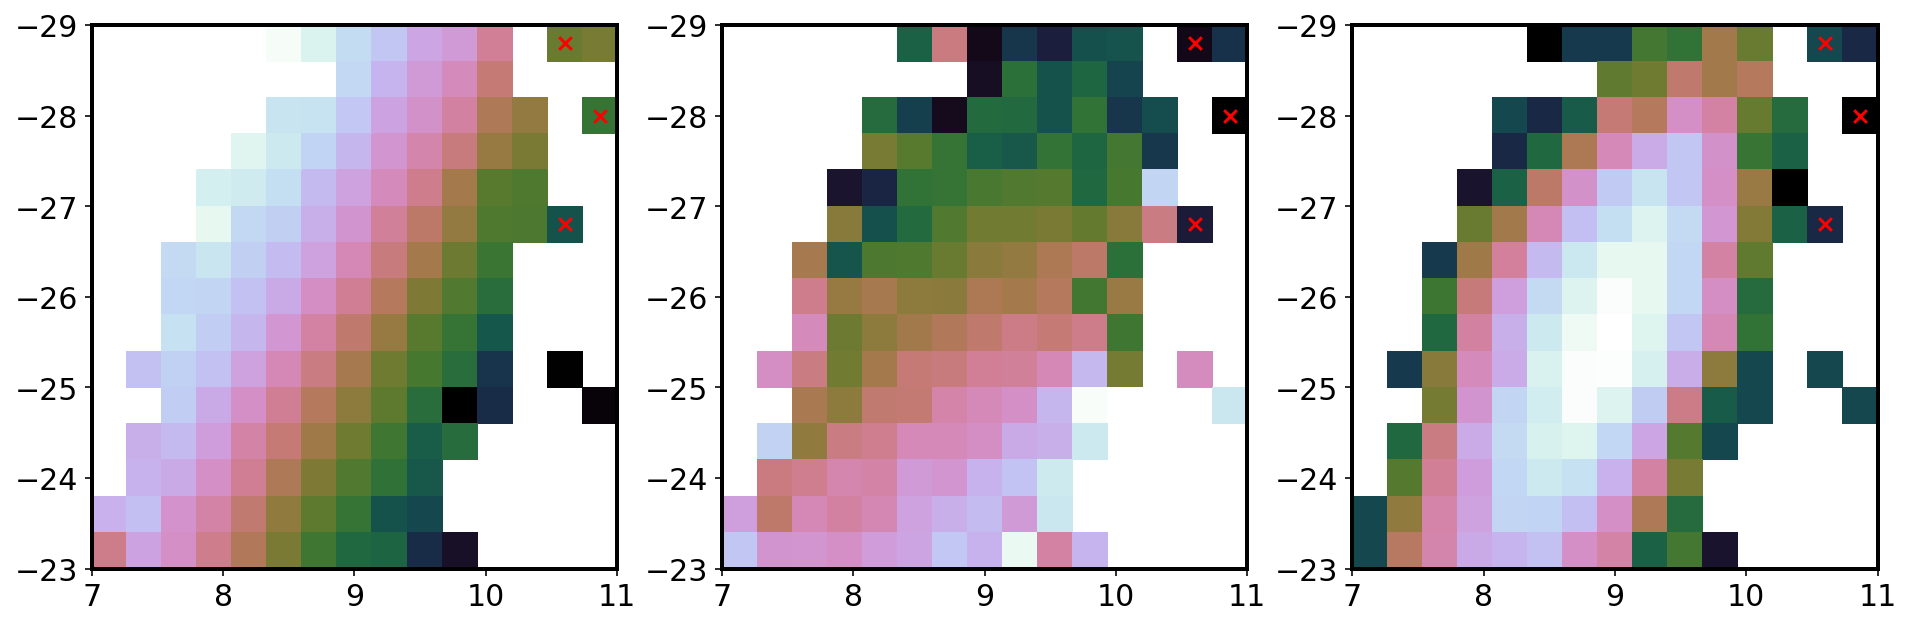

In [428]:
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram2d.html
xmin, xmax = extent0[0],extent0[1]
ymin, ymax = extent0[3],extent0[2]


stats = binned_statistic_2d(MBH[m], MI[m], logEddRatio[m], 
                         statistic='median', bins=gridsize, 
                        range = [[xmin,xmax], [ymin,ymax]])

stats1 = binned_statistic_2d(MBH, MI, np.log10(sf4000), 
                         statistic='median', bins=gridsize, 
                        range = [[xmin,xmax], [ymin,ymax]])

stats2 =  binned_statistic_2d(MBH, MI, MI, 
                         statistic='count', bins=gridsize, 
                         range = [[xmin,xmax], [ymin,ymax]])



fig,axs = plt.subplots(1,3, figsize=(16,5))
ax  = np.ravel(axs)

# left : log (fEdd )
H = stats[0].T
xedges, yedges = stats[1], stats[2 ]
X,Y = np.meshgrid(xedges, yedges)

image = ax[0].pcolormesh(X,Y,H , cmap=cmap) 

# middle : log (SFinf )
H1 = stats1[0].T
#xedges, yedges = stats1[1], stats1[2 ]
#X,Y = np.meshgrid(xedges, yedges)

image = ax[1].pcolormesh(X,Y,H1 , cmap=cmap) 


# right 
H2 = stats2[0].T
image = ax[2].pcolormesh(X,Y,np.log10(H2) , cmap=cmap) 



#sel  = np.where(H == 5 )
sel = np.where((H1 < -1.2) & (H < -1 ) )


dX = xedges[1]-xedges[0]
XC = X+dX/2

dY = yedges[1]-yedges[0]
YC = Y+dY/2 

for i in range(len(ax)):
    ax[i].scatter(XC[sel], YC[sel], marker='x', s=40,c='red')
    ax[i].invert_yaxis()



/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


(array([0, 0, 0, 1, 2, 2, 4, 4, 5]),
 array([ 7,  9, 13,  7,  6, 14,  3,  4, 13]))

Above I marked with crosses centers of bins which have exactly 5 counts.... 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


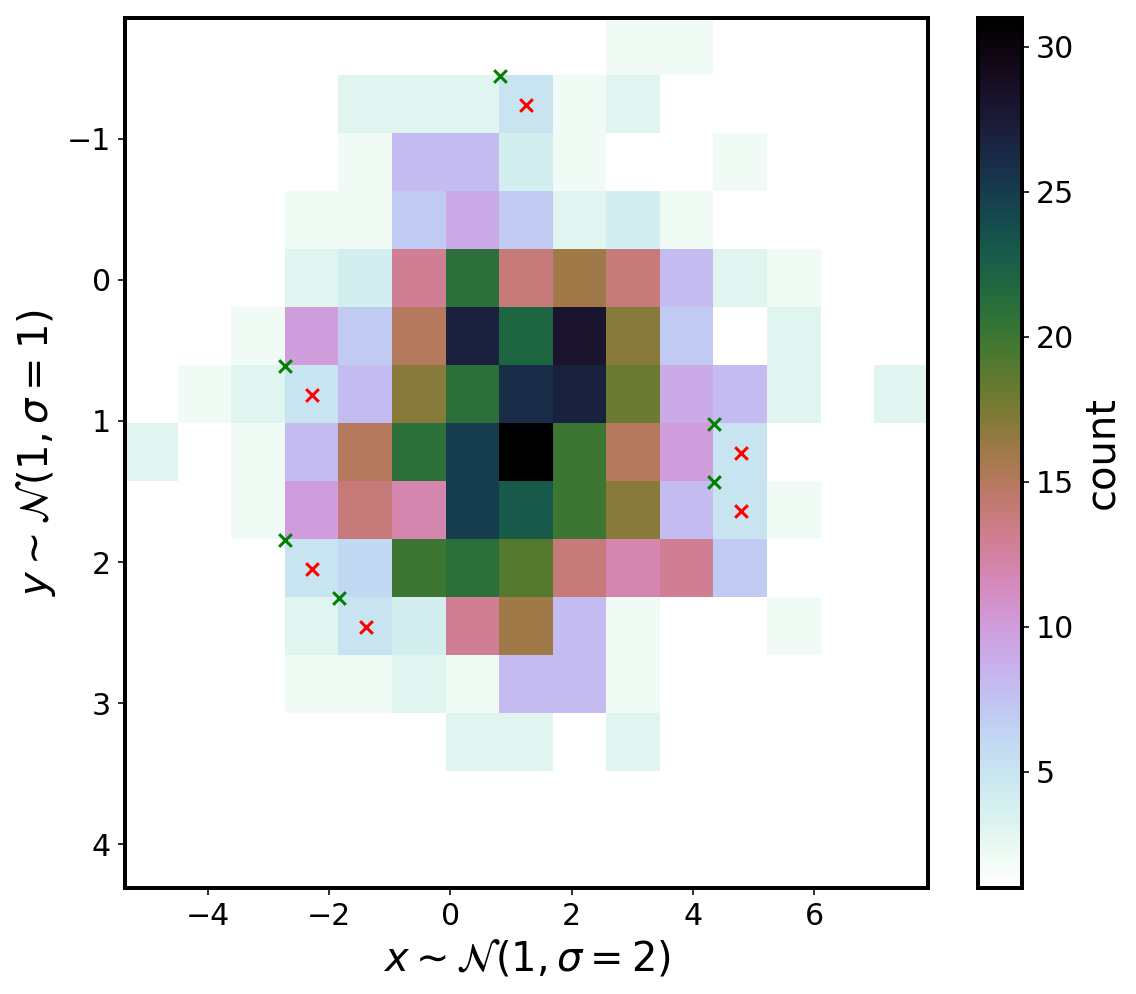

In [386]:
np.random.seed(40)
x = np.random.normal(1,2,1000)
y = np.random.normal(1,1,1000)

stats =  binned_statistic_2d(x,y,y, statistic='count', bins=15)
fig,ax = plt.subplots(1,1, figsize=(9,8))

H = stats[0].T # no need to do rot and flipud!!!! 
#  Z.T === np.flipup(np.rot90(Z))

xedges, yedges = stats[1], stats[2]
X, Y = np.meshgrid(xedges, yedges)
image = ax.pcolormesh(X, Y, H, cmap='cubehelix_r', vmin=1)
plt.colorbar(image, label = 'count')
sel = np.where(H == 5)

dX = xedges[1]-xedges[0]
XC = X+dX/2

dY = yedges[1]-yedges[0]
YC = Y+dY/2 

ax.scatter(X[sel], Y[sel], marker='x', c='green',s=40)
ax.scatter(XC[sel], YC[sel], marker='x', s=40,c='red')
ax.set_xlabel(r'$x \sim \mathcal{N}(1,\sigma=2)$')
ax.set_ylabel(r'$y \sim \mathcal{N}(1,\sigma=1)$')

ax.invert_yaxis()

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


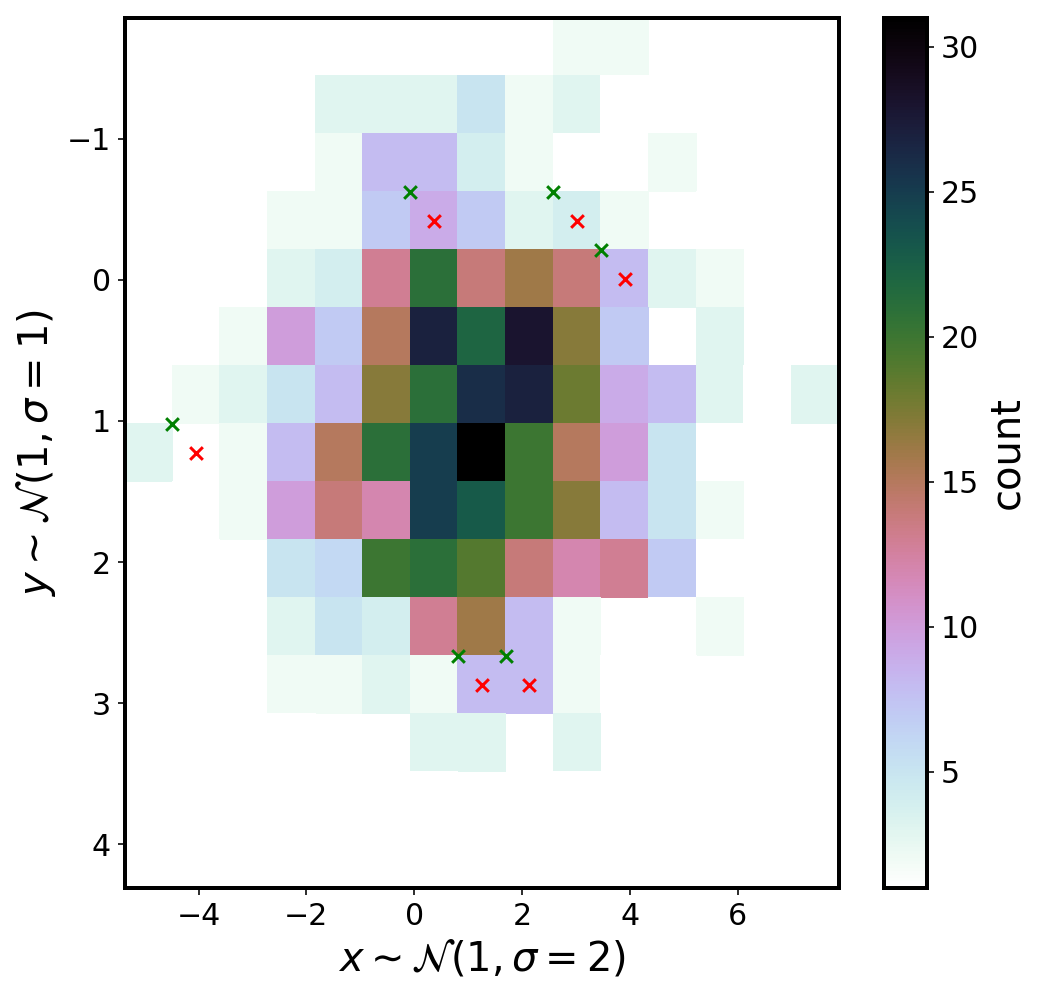

In [385]:
# NOTE : the code below is NOT EQUIVALENT 
# to the code above - for some reason
# plotting with imshow with   xedges,yedges,zmasked 
# is different than with X,Y,H ...
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram2d.html
np.random.seed(40)
x = np.random.normal(1,2,1000)
y = np.random.normal(1,1,1000)

stats =  binned_statistic_2d(x,y,y, statistic='count', bins=15)

fig,ax = plt.subplots(1,1, figsize=(8,8))

z_stat, xedges, yedges = stats[0], stats[1], stats[2]
X, Y = np.meshgrid(xedges, yedges)
# replace all nan's by 0 ...
z_stat[np.isnan(z_stat)] = 0 

# replace all low values by 0 
#z_stat[z_stat<-100] = 0 

z_rot = np.rot90(z_stat)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
zmasked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

#image = ax.pcolormesh(xedges,yedges,zmasked, cmap='cubehelix_r',
#                     vmin=1) 
image = ax.pcolormesh(X,Y,zmasked, cmap='cubehelix_r',    vmin=1) 
plt.colorbar(image, label = 'count')
sel = np.where(z_stat == 5)

dX = xedges[1]-xedges[0]
XC = X+dX/2

dY = yedges[1]-yedges[0]
YC = Y+dY/2 

ax.scatter(X[sel], Y[sel], marker='x', c='green',s=40)
ax.scatter(XC[sel], YC[sel], marker='x', s=40,c='red')
ax.set_xlabel(r'$x \sim \mathcal{N}(1,\sigma=2)$')
ax.set_ylabel(r'$y \sim \mathcal{N}(1,\sigma=1)$')

ax.invert_yaxis()

In [305]:
X, Y = np.meshgrid(xedges, yedges)X, Y = np.meshgrid(xedges, yedges)

array([[ 7.26666667,  7.53333333,  7.8       ,  8.06666667,  8.33333333,
         8.6       ,  8.86666667,  9.13333333,  9.4       ,  9.66666667,
         9.93333333, 10.2       , 10.46666667, 10.73333333, 11.        ,
        11.26666667],
       [ 7.26666667,  7.53333333,  7.8       ,  8.06666667,  8.33333333,
         8.6       ,  8.86666667,  9.13333333,  9.4       ,  9.66666667,
         9.93333333, 10.2       , 10.46666667, 10.73333333, 11.        ,
        11.26666667],
       [ 7.26666667,  7.53333333,  7.8       ,  8.06666667,  8.33333333,
         8.6       ,  8.86666667,  9.13333333,  9.4       ,  9.66666667,
         9.93333333, 10.2       , 10.46666667, 10.73333333, 11.        ,
        11.26666667],
       [ 7.26666667,  7.53333333,  7.8       ,  8.06666667,  8.33333333,
         8.6       ,  8.86666667,  9.13333333,  9.4       ,  9.66666667,
         9.93333333, 10.2       , 10.46666667, 10.73333333, 11.        ,
        11.26666667],
       [ 7.26666667,  7.53333333,  7

In [294]:
# this shows that the two operations 
# are exactly equivalent !~!! 
stats[0].T == np.flipud(np.rot90(stats[0]))

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True],
       [ True,  True,  T

array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        4.000e+00, 4.000e+00, 1.500e+01, 1.200e+01, 3.700e+01, 2.200e+01,
        0.000e+00, 5.000e+00, 3.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+01, 2.300e+01, 5.400e+01, 3.700e+01, 4.600e+01,
        0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 5.000e+00, 3.000e+00,
        7.000e+00, 5.800e+01, 4.700e+01, 1.200e+02, 8.700e+01, 2.100e+01,
        1.000e+01, 0.000e+00, 1.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 9.000e+00,
        4.200e+01, 1.040e+02, 1.950e+02, 2.970e+02, 1.240e+02, 1.300e+01,
        8.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 8.000e+00, 5.000e+01,
        1.250e+02, 3.150e+02, 5.060e+02, 2.930e+02, 1.210e+02, 3.400e+01,
        1.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 2.200e+01

In [289]:
H.T

array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 5.000e+00, 5.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 0.000e+00, 9.000e+00,
        1.800e+01, 3.100e+01, 4.800e+01],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        4.000e+00, 1.400e+01, 9.000e+00, 2.900e+01, 2.400e+01, 6.500e+01,
        7.700e+01, 9.000e+01, 9.300e+01],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.200e+01,
        3.600e+01, 5.900e+01, 8.400e+01, 1.070e+02, 1.320e+02, 1.920e+02,
        1.540e+02, 1.640e+02, 1.880e+02],
       [0.000e+00, 0.000e+00, 5.000e+00, 3.000e+00, 8.000e+00, 3.700e+01,
        8.200e+01, 1.600e+02, 2.030e+02, 1.970e+02, 3.850e+02, 4.100e+02,
        3.880e+02, 3.830e+02, 2.240e+02],
       [1.000e+00, 0.000e+00, 3.000e+00, 9.000e+00

In [264]:
ax.imshow?

In [255]:
y_cen

array([-28.8, -28.4, -28. , -27.6, -27.2, -26.8, -26.4, -26. , -25.6,
       -25.2, -24.8, -24.4, -24. , -23.6, -23.2])

In [239]:
np.log10(stats_count.statistic)

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


array([[      -inf,       -inf,       -inf,       -inf,       -inf,
              -inf,       -inf,       -inf,       -inf,       -inf,
              -inf,       -inf,       -inf, 0.69897   , 0.69897   ],
       [      -inf,       -inf,       -inf,       -inf,       -inf,
              -inf,       -inf,       -inf,       -inf, 0.60205999,
              -inf, 0.95424251, 1.25527251, 1.49136169, 1.68124124],
       [      -inf,       -inf,       -inf,       -inf,       -inf,
              -inf, 0.60205999, 1.14612804, 0.95424251, 1.462398  ,
        1.38021124, 1.81291336, 1.88649073, 1.95424251, 1.96848295],
       [      -inf,       -inf,       -inf,       -inf, 0.30103   ,
        1.34242268, 1.5563025 , 1.77085201, 1.92427929, 2.02938378,
        2.12057393, 2.28330123, 2.18752072, 2.21484385, 2.27415785],
       [      -inf,       -inf, 0.69897   , 0.47712125, 0.90308999,
        1.56820172, 1.91381385, 2.20411998, 2.30749604, 2.29446623,
        2.58546073, 2.61278386, 2.58883173, 

In [231]:
x_edge = stats_med_fEdd.x_edge
y_edge = stats_med_fEdd.y_edge


array([-29. , -28.6, -28.2, -27.8, -27.4, -27. , -26.6, -26.2, -25.8,
       -25.4, -25. , -24.6, -24.2, -23.8, -23.4, -23. ])

In [234]:
np.meshgrid(x_edge,y_edge)

[array([[ 7.        ,  7.26666667,  7.53333333,  7.8       ,  8.06666667,
          8.33333333,  8.6       ,  8.86666667,  9.13333333,  9.4       ,
          9.66666667,  9.93333333, 10.2       , 10.46666667, 10.73333333,
         11.        ],
        [ 7.        ,  7.26666667,  7.53333333,  7.8       ,  8.06666667,
          8.33333333,  8.6       ,  8.86666667,  9.13333333,  9.4       ,
          9.66666667,  9.93333333, 10.2       , 10.46666667, 10.73333333,
         11.        ],
        [ 7.        ,  7.26666667,  7.53333333,  7.8       ,  8.06666667,
          8.33333333,  8.6       ,  8.86666667,  9.13333333,  9.4       ,
          9.66666667,  9.93333333, 10.2       , 10.46666667, 10.73333333,
         11.        ],
        [ 7.        ,  7.26666667,  7.53333333,  7.8       ,  8.06666667,
          8.33333333,  8.6       ,  8.86666667,  9.13333333,  9.4       ,
          9.66666667,  9.93333333, 10.2       , 10.46666667, 10.73333333,
         11.        ],
        [ 7.        

In [99]:
#newshape  = np.array(np.shape([x,y])).T
xy = np.reshape([x,y], newshape=[len(x),2] )

In [104]:
m = (x<-1) & (y<-1.2)
xy = Table([x,y], names=['log_fEdd', 'log_SFinf'])
xy[m]

log_fEdd,log_SFinf
float64,float64
-1.3559696446572218,-1.318166329575365
-2.01156450969016,-1.247930887667306
-1.63223552746868,-1.374522383624866


In [141]:
bin_med_sf4000 = stats_med_sf4000[0]
bin_med_fEdd = stats_med_fEdd[0]

x_,y_  = np.log10(bin_med_fEdd), np.log10(bin_med_sf4000)


In [145]:
x_[mremove]

array([-1.35596964, -2.01156451, -1.63223553])

In [147]:
np.log10(stats_med_sf4000.statistic[mremove])

array([-1.31816633, -1.24793089, -1.37452238])

In [150]:
np.shape(stats_med_sf4000.statistic)

(15, 15)

In [151]:
np.shape(stats_med_sf4000.binnumber)

(2, 33218)

In [167]:
# absolute i-band magnitude K-corr to z=2 
MI =data['MI_Z2'] # Shen2011 

# redshift  : Shen2011 
z =  data['REDSHIFT']

# black hole mass from Shen+2011
MBH = data['LOGBH']

# Eddington ratio : Shen2011
# log(L/LEdd ) = log( L / 1.26e38 MBH / Msun)

logEddRatio = data['LOGEDD_RATIO'] 

sf4000 = data['SFinf4000']


m2 = data['Plike'] - data['Pnoise'] > 2 
m3 = data['Plike'] - data['Pinf'] > 0.05 
m4 = data['edge'] == 0 
m = m2&m3&m4
print(np.sum(m))

stats_med_sf4000 = binned_statistic_2d(MBH[m].data, MI[m].data, sf4000[m].data, 
                         statistic='median', bins=gridsize, 
                        range = [[xmin,xmax], [ymin,ymax]],
                                      expand_binnumbers=True)

33218


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [168]:
stats_med_sf4000

BinnedStatistic2dResult(statistic=array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan

In [156]:
m

array([ True,  True,  True, ...,  True,  True,  True])

### Chelsea's slope:  -0.23 +/- 0.03  ....  I get -0.166 !! 

POLYFIT  slope a =  -0.1660241914068823


(-2.234854576838457, 0.5148990843999544)

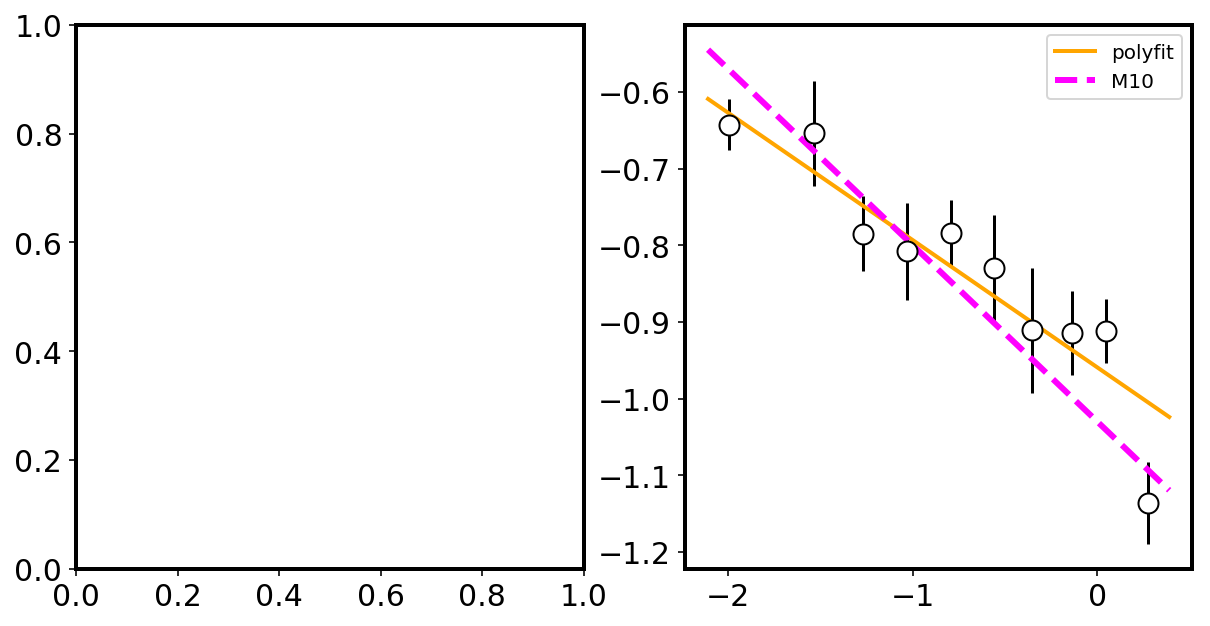

In [219]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[1].errorbar(bin_centers1, stat_med, sigma_median, fmt='o', mec = 'black', mfc='white',
            ecolor = 'black', capthick=2,
           markersize=10)




# fit with the straight line 
sy = sigma_median  * np.ones_like(stat_med)
z = np.polyfit(bin_centers1, stat_med,1, w = 1 / sy)
a_fit_poly,  b_fit_poly  = z 
print('POLYFIT  slope a = ', a_fit_poly)
# use poly1 object for plotting the straight line 
p1 = np.poly1d(z) # 
xmin, xmax = ax[1].get_xlim()
xp = np.linspace(xmin,xmax,1000)
ax[1].plot(xp, p1(xp), ls='-', lw=2, c='orange',label='polyfit')

ax[1].plot(xp, -0.23*xp - 1.03, lw=3, ls='--', c='magenta', label='M10')



ax[1].legend()
ax[1].get_xbound()

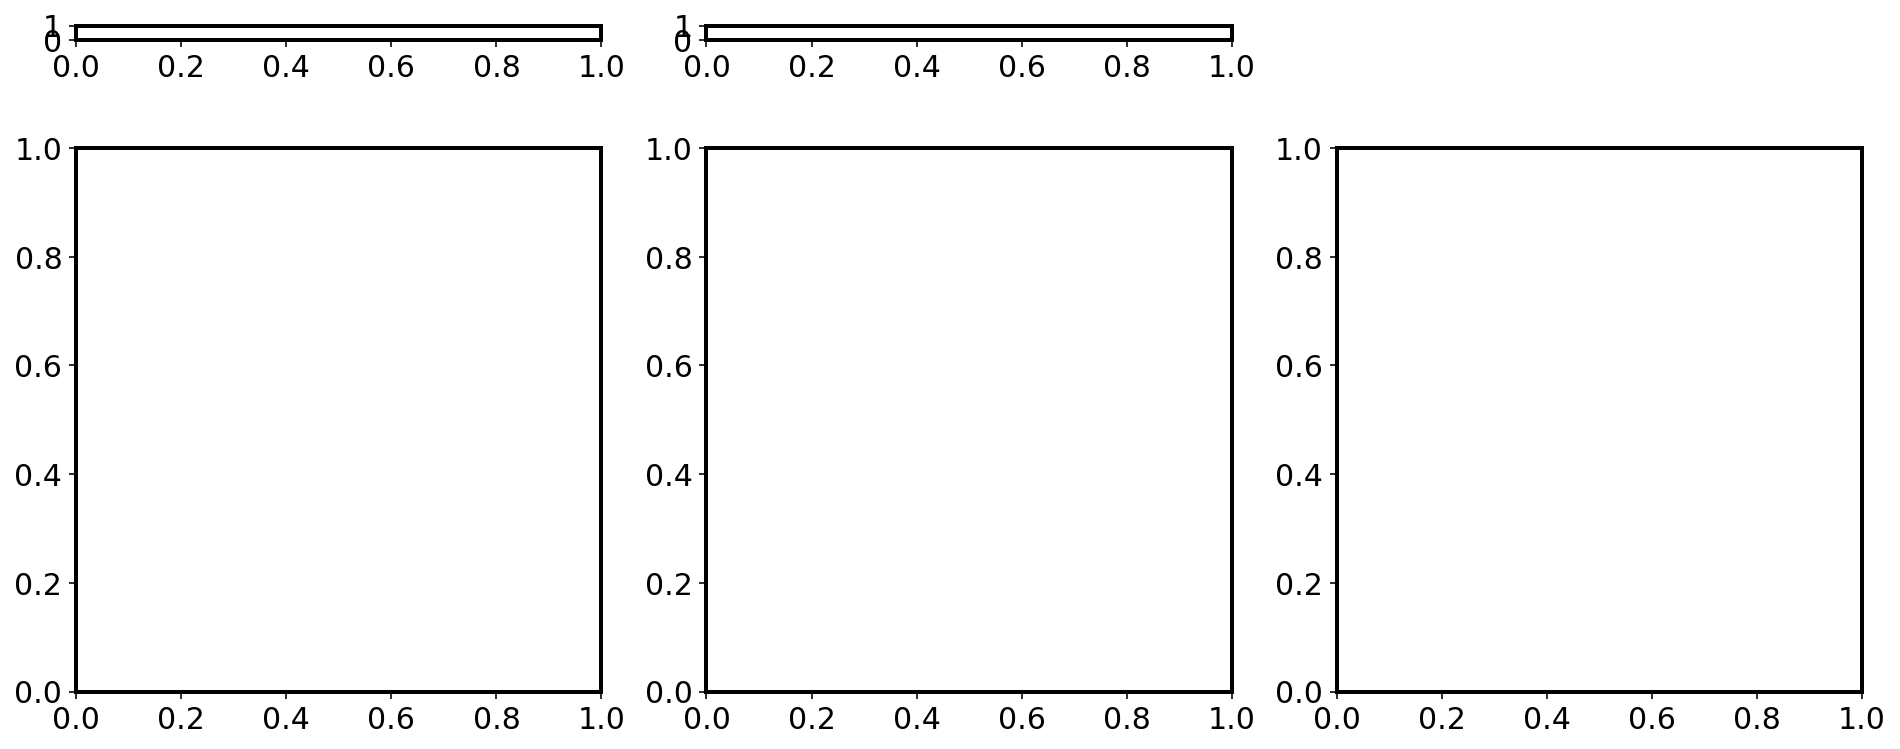

In [245]:
fig,axs = plt.subplots(1,3, figsize=(16,5))
ax = np.ravel(axs)

# set bottom and height for colorbar 
bottom, height =  1.03, 0.02

# get left and right coordinates in figure units 
# for left axis 
l,b,w,h = ax[0].get_position().bounds
cax = fig.add_axes([l,bottom,w,height])

# get left and right coordinates in figure units 
# for middle axis 
l,b,w,h = ax[1].get_position().bounds
cax = fig.add_axes([l,bottom,w,height])



In [238]:
l,b,w,h = ax[0].get_position().bounds

In [242]:
h

0.755

In [ ]:
.get_position

In [ ]:
ax[0].get_position

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Text(0.5, 0, '$\\log_{10}{(L_{bol} / L_{Edd})}$')

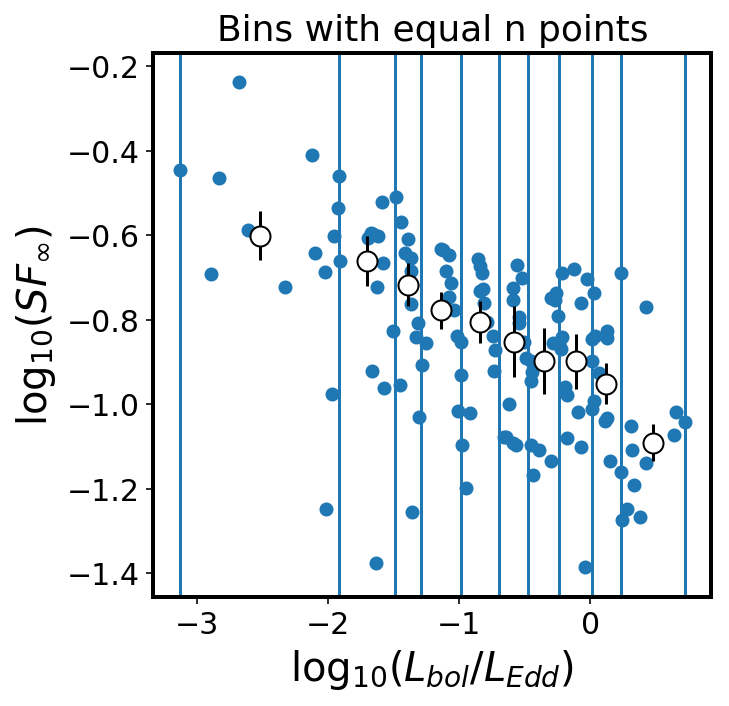

In [144]:
# Show how the code works....

x,y  = np.log10(bin_med_fEdd), np.log10(bin_med_sf4000)

def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt), np.sort(x))
fig,ax = plt.subplots(1,1, figsize=(5,5))
ax.scatter(x,y)

bin_edges  = histedges_equalN(x, 10)
for edge in bin_edges : 
    ax.axvline(edge)
#bin_centers  =  (bin_edges[1:] + bin_edges[:-1] ) /2.
stat_med, bin_edges1,  binnumber = bs(x,y,statistic='median', bins=bin_edges)
bin_centers1 = (bin_edges1[1:] + bin_edges1[:-1] ) /2.


# get the count per bin
stat_count, bin_edges1,  binnumber = bs(x,x,statistic='count', bins=bin_edges)
ax.set_title('Bins with equal n points')  
N = stat_count[0]

# get the RMS, estimated by sigmaG,  per bin 
sigmaG = lambda x : 0.7413*(np.percentile(x,75) - np.percentile(x,25))
stat_RMS, bin_edges1,  binnumber = bs(x,y,statistic=sigmaG, bins=bin_edges)

sigma_median = 1.25 * stat_RMS / np.sqrt(N)
# markeredgecolor or mec
# markeredgewidth or mew
# markerfacecolor or mfc
# ecolor specifies the color of errorbar(s) 
ax.errorbar(bin_centers1, stat_med, sigma_median,fmt='o', mec = 'black', mfc='white',
            ecolor = 'black', capthick=2,
           markersize=10)
ax.set_ylabel(r'$\log_{10}{(SF_{\infty})}$')
ax.set_xlabel(r'$\log_{10}{(L_{bol} / L_{Edd})}$')



In [126]:
x

array([-0.30087571,  0.0263849 , -0.55920225, -0.27046474,  0.01602586,
        0.23659088,  0.12854175, -0.84366359, -0.59155624, -0.28508744,
        0.06477038,  0.31679818,  0.37541129, -1.07969459, -0.8194424 ,
       -0.54718553, -0.24222959,  0.02885637,  0.30843883,  0.71850147,
       -1.39180667, -1.12518531, -0.84028136, -0.50302623, -0.19367564,
        0.12321018,  0.23463722, -1.6168026 , -1.41086777, -1.06547525,
       -0.78447702, -0.454815  , -0.17679769,  0.1511204 , -1.92134625,
       -1.66840487, -1.36509403, -1.04267037, -0.72925622, -0.45480497,
       -0.09193093,  0.24474655, -2.32586217, -1.91151714, -1.65849767,
       -1.36584029, -0.98334717, -0.61849474, -0.39463535,  0.01292484,
       -2.67386766, -1.90488668, -1.62583539, -1.31210592, -0.91635659,
       -0.64066424, -0.2988823 , -3.12547761, -1.96972914, -1.57072852,
       -1.44700648, -0.94601786, -0.56392751, -1.48335235, -1.25566742,
       -2.82950905, -2.89140804, -1.63223553, -1.35596964, -0.21

In [128]:

sigmaG(x)

0.881813378376164

## Binned Statistic with equal number of points per bin ... 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Text(0.5, 1.0, 'Bins with equal n points')

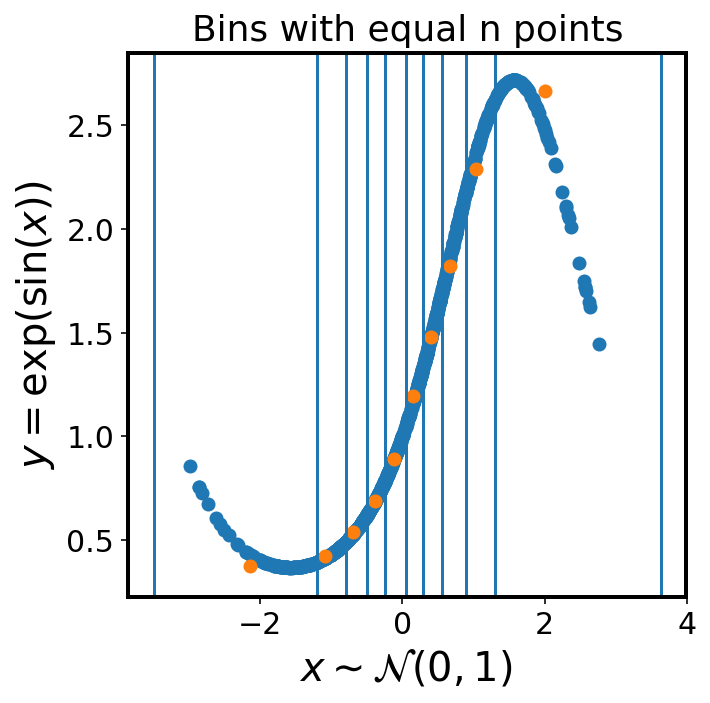

In [108]:
from scipy.stats import binned_statistic as bs 

# histogram with non-constant bin widths 
# the code from 
# https://stackoverflow.com/questions/5328556/histogram-matplotlib/5328669#5328669
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt), np.sort(x))
# test ... 
x = np.random.randn(1000)
y = np.exp(np.sin(x))

fig,ax = plt.subplots(1,1, figsize=(5,5))
ax.scatter(x,y)
ax.set_xlabel(r'$x \sim \mathcal{N}(0,1)$ ')
ax.set_ylabel(r'$y  = \exp{(\sin(x))}$')

for edge in bin_edges : 
    ax.axvline(edge)
    #ax[1].axvline(edge)
    
# find out bin edges 
bin_edges  = histedges_equalN(x, 10)
bin_centers  =  (bin_edges[1:] + bin_edges[:-1] ) /2.
statistic, bin_edges1,  binnumber = bs(x,y,statistic='median', bins=bin_edges)
bin_centers1 = (bin_edges1[1:] + bin_edges1[:-1] ) /2.
ax.scatter(bin_centers1, statistic,)
ax.set_title('Bins with equal n points')

In [110]:
statistic, bin_edges1,  binnumber = bs(x,x,statistic='count', bins=bin_edges)
statistic

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100.])

Illustration of bins defined so that there is an equal number of points per bin. 
Thus the histogram of `x`  in these bins would be a flat line. On the right the histogram shows the median of y values . It shows that this method basically works. 

In [84]:
# at the values of hexagon centers,  plot the median fEdd vs SFinf .... 
bin_edges

array([-2.10717322, -1.46500645, -1.00217234, -0.78922397, -0.39007787,
       -0.0779742 ,  0.16737734,  0.33167501,  0.72847736,  1.14569355,
        1.94932837])

In [11]:
# Chelsea first plots the histogram on the left panel , and 
# in each square bin computes the median value of SFinf and LEdd... 

In [14]:
# getting bin coordinates
# https://stackoverflow.com/questions/12951065/get-bins-coordinates-with-hexbin-in-matplotlib
    

In [30]:
image.get_offsets()

array([[  7.2       , -23.        ],
       [  7.2       , -23.54545455],
       [  7.2       , -25.18181818],
       [  7.4       , -23.        ],
       [  7.4       , -23.54545455],
       [  7.4       , -24.09090909],
       [  7.4       , -25.18181818],
       [  7.6       , -23.        ],
       [  7.6       , -23.54545455],
       [  7.6       , -24.09090909],
       [  7.6       , -24.63636364],
       [  7.6       , -25.18181818],
       [  7.6       , -25.72727273],
       [  7.8       , -23.        ],
       [  7.8       , -23.54545455],
       [  7.8       , -24.09090909],
       [  7.8       , -24.63636364],
       [  7.8       , -25.18181818],
       [  7.8       , -25.72727273],
       [  7.8       , -26.27272727],
       [  8.        , -23.        ],
       [  8.        , -23.54545455],
       [  8.        , -24.09090909],
       [  8.        , -24.63636364],
       [  8.        , -25.18181818],
       [  8.        , -25.72727273],
       [  8.        , -26.27272727],
 

In [31]:
image1.get_offsets()

array([[  7.2       , -23.        ],
       [  7.2       , -23.54545455],
       [  7.2       , -25.18181818],
       [  7.4       , -23.        ],
       [  7.4       , -23.54545455],
       [  7.4       , -24.09090909],
       [  7.4       , -25.18181818],
       [  7.6       , -23.        ],
       [  7.6       , -23.54545455],
       [  7.6       , -24.09090909],
       [  7.6       , -24.63636364],
       [  7.6       , -25.18181818],
       [  7.6       , -25.72727273],
       [  7.8       , -23.        ],
       [  7.8       , -23.54545455],
       [  7.8       , -24.09090909],
       [  7.8       , -24.63636364],
       [  7.8       , -25.18181818],
       [  7.8       , -25.72727273],
       [  7.8       , -26.27272727],
       [  8.        , -23.        ],
       [  8.        , -23.54545455],
       [  8.        , -24.09090909],
       [  8.        , -24.63636364],
       [  8.        , -25.18181818],
       [  8.        , -25.72727273],
       [  8.        , -26.27272727],
 

In [16]:
image.get_array()

array([-0.43156726, -0.18373575, -0.12679275, -0.29355471, -0.13909085,
       -0.18240225, -0.02739577, -0.47476886, -0.37289954, -0.17423032,
        0.04858344, -0.04305458,  0.27719177, -0.68442701, -0.478091  ,
       -0.32577888, -0.25815831, -0.02503721,  0.14212648,  0.19914971,
       -0.90788666, -0.80454509, -0.57599574, -0.34950361, -0.12317688,
        0.00832809,  0.11964936,  0.44417582,  0.37541129, -1.11705791,
       -0.92005345, -0.72963653, -0.57015019, -0.34040152, -0.11570986,
        0.09444577,  0.23895738,  0.26526945,  0.71850147, -1.30029083,
       -1.10443785, -0.93021651, -0.72474236, -0.49667343, -0.33260462,
       -0.10746726,  0.06022157,  0.26480536,  0.42444604, -1.51743282,
       -1.30021311, -1.11912044, -0.91478712, -0.71253533, -0.50083139,
       -0.29017531, -0.09879583,  0.11390398,  0.2467696 , -1.65333465,
       -1.51579571, -1.27938449, -1.07821893, -0.8852171 , -0.67798529,
       -0.48126319, -0.25130218, -0.13867288,  0.07967485,  0.40

In [22]:
plt.hexbin?